In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# For graph plotting style
plt.style.use('seaborn-v0_8-whitegrid')

#No System Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
Ticker = "QQQ" # Insert the ETF Ticker that you wish to test Here, e.g. "QQQE"

In [6]:
ETF_filename_no_features = f"..//resources/raw_files/yfinance/{Ticker}_1d_data.csv"
ETF_filename_features = f"..//resources/featured_files/yfinance/{Ticker}_1d_features.csv"

feat_df = pd.read_csv(ETF_filename_features)
no_feat_df = pd.read_csv(ETF_filename_no_features)

In [7]:
no_feat_df.shape, feat_df.shape,

((1507, 9), (1507, 32))

In [8]:
feat_df.isnull().sum(), no_feat_df.isnull().sum()

(Date                       0
 Ticker                     0
 Open                       0
 High                       0
 Low                        0
 Close                      0
 Volume                     0
 Dividends                  0
 Stock Splits               0
 Capital Gains              0
 Price_Movement             0
 Price_Movement_Pct         0
 Year                       0
 Month                      0
 Day                        0
 Day_of_Year                0
 Day_of_Week                0
 quarter                    0
 Close_lag1                 0
 Close_lag3                 0
 Close_lag5                 0
 Close_lag7                 0
 Close_lag14                0
 Close_lag21                0
 Close_lag28                0
 Close_lag365               0
 Month_Sin                  0
 Month_Cos                  0
 Dayofweek_Sin              0
 Dayofweek_Cos              0
 Price_Movement_Category    0
 Price_Movement_Code        0
 dtype: int64,
 Date             0
 Open

In [9]:
econ_data_df = pd.read_csv(r"../resources/raw_files/fred/fred_macro_data.csv")

In [10]:
merged_feat = feat_df.merge(econ_data_df, on="Date", how="inner")  
merged_no_feat = no_feat_df.merge(econ_data_df, on="Date", how="inner")  

In [11]:
merged_feat.head(), merged_no_feat.head()

(         Date Ticker        Open        High         Low       Close  \
 0  2020-01-03    QQQ  205.820530  207.914436  205.801227  206.669662   
 1  2020-01-06    QQQ  205.048584  208.030229  204.797707  208.001282   
 2  2020-01-07    QQQ  208.078464  208.560931  207.316172  207.972321   
 3  2020-01-08    QQQ  207.943386  210.490813  207.615312  209.535522   
 4  2020-01-09    QQQ  211.262755  211.716275  210.075890  211.311005   
 
      Volume  Dividends  Stock Splits  Capital Gains  ...  \
 0  27518900        0.0           0.0            0.0  ...   
 1  21655300        0.0           0.0            0.0  ...   
 2  22139300        0.0           0.0            0.0  ...   
 3  26397300        0.0           0.0            0.0  ...   
 4  23547000        0.0           0.0            0.0  ...   
 
    U_Mich_Consumer_Sentiment  Chicago_Fed_National_Activity_Index  \
 0                       99.8                                -0.25   
 1                       99.8                       

In [12]:
merged_no_feat.info(), merged_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 55 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       1506 non-null   object 
 1   Open                                       1506 non-null   float64
 2   High                                       1506 non-null   float64
 3   Low                                        1506 non-null   float64
 4   Close                                      1506 non-null   float64
 5   Volume                                     1506 non-null   int64  
 6   Dividends                                  1506 non-null   float64
 7   Stock Splits                               1506 non-null   float64
 8   Capital Gains                              1506 non-null   float64
 9   GDP                                        1506 non-null   float64
 10  CPI_Inflation           

(None, None)

In [13]:
drop_list_feat =merged_feat.select_dtypes(include=['object']).columns.to_list()
drop_list_no_feat = merged_no_feat.select_dtypes(include=['object']).columns.to_list()

In [14]:
drop_list_feat, drop_list_no_feat

(['Date', 'Ticker', 'Price_Movement_Category'], ['Date'])

In [15]:
merged_no_feat = merged_no_feat.drop(drop_list_no_feat,axis=1)
merged_feat = merged_feat.drop(drop_list_feat,axis=1)

In [16]:
merged_no_feat = merged_no_feat.fillna(0)
merged_feat = merged_feat.fillna(0)

In [17]:
X_no_feat = merged_no_feat.drop(['Close','Open', 'High', 'Low'], axis=1)
Y_no_feat = merged_no_feat['Close']

X_feat = merged_feat.drop(['Close','Open', 'High', 'Low'], axis=1)
Y_feat = merged_feat['Close']   

In [18]:
X_train_no_feat, X_test_no_feat, y_train_no_feat, y_test_no_feat = train_test_split(
    X_no_feat, 
    Y_no_feat, 
    test_size=0.2, 
    random_state=42
)

print(f"Training on {len(X_train_no_feat)} ETF prices - no feature engineering")
print(f"Testing on {len(X_test_no_feat)} ETF prices - no feature engineering")

X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, 
    Y_feat, 
    test_size=0.2, 
    random_state=42
)

print(f"\nTraining on {len(X_train_feat)} ETF prices - with feature engineering")
print(f"Testing on {len(X_test_feat)} ETF prices - with feature engineering")

Training on 1204 ETF prices - no feature engineering
Testing on 302 ETF prices - no feature engineering

Training on 1204 ETF prices - with feature engineering
Testing on 302 ETF prices - with feature engineering


In [19]:
# Train the regression model
model_no_feat = LinearRegression()
model_no_feat.fit(X_train_no_feat, y_train_no_feat)

model_feat = LinearRegression()
model_feat.fit(X_train_feat, y_train_feat)

# Make predictions
y_pred_no_feat = model_no_feat.predict(X_test_no_feat)
y_pred_feat = model_feat.predict(X_test_feat)

In [20]:
y_pred_no_feat, y_pred_feat

(array([333.47589989, 460.21510373, 345.23678095, 313.98481048,
        372.48793637, 466.23909326, 273.59192133, 431.66140275,
        261.51899123, 452.00078137, 591.99362627, 619.2366003 ,
        309.96149236, 358.81855047, 304.3927414 , 441.93533708,
        298.03615857, 363.53845864, 385.88981659, 382.99069112,
        374.90469232, 460.45877888, 322.89127197, 337.53026602,
        357.07408636, 616.93490745, 510.06851448, 349.55314847,
        598.20835451, 605.6414273 , 362.5386663 , 570.37700357,
        509.11251186, 262.10142308, 337.59681929, 379.23613968,
        305.99388725, 265.25138282, 468.25268627, 513.4442377 ,
        468.25244579, 295.30714611, 557.35520018, 197.05418575,
        471.26280389, 359.1729931 , 437.65890201, 297.05749655,
        335.674969  , 144.09245662, 283.40704557, 358.89475758,
        306.06025364, 359.17224109, 574.84409268, 291.81741194,
        294.88897002, 360.76303543, 277.78174135, 466.17338239,
        140.52023265, 203.04316345, 302.

In [21]:
# Calculate metrics
mae_no_feat = mean_absolute_error(y_test_no_feat, y_pred_no_feat)
r2_no_feat = r2_score(y_test_no_feat, y_pred_no_feat)
mae_feat = mean_absolute_error(y_test_feat, y_pred_feat)
r2_feat = r2_score(y_test_feat, y_pred_feat)

print(f"{Ticker}: Mean Absolute Error (MAE)")
print()
print(f"   Your MAE : USD {mae_no_feat:,.0f} (without feature engineering) ; USD {mae_feat:,.0f} (with feature engineering)")
print()
print("   What it means: On average, our predictions are off by this much")
print("   Goal: Lower is better!")
print()
print(f"{Ticker}: R² Score (R-squared)")
print()
print(f"   Your R² : {r2_no_feat:.1%} (without feature engineering) ; {r2_feat:.1%} (with feature engineering)")
print()
print("   What it means: How much of the ETF's Close price variation we can explain")
print("   Goal: Higher is better (100% = perfect, 0% = terrible)")

QQQ: Mean Absolute Error (MAE)

   Your MAE : USD 8 (without feature engineering) ; USD 2 (with feature engineering)

   What it means: On average, our predictions are off by this much
   Goal: Lower is better!

QQQ: R² Score (R-squared)

   Your R² : 99.3% (without feature engineering) ; 99.9% (with feature engineering)

   What it means: How much of the ETF's Close price variation we can explain
   Goal: Higher is better (100% = perfect, 0% = terrible)


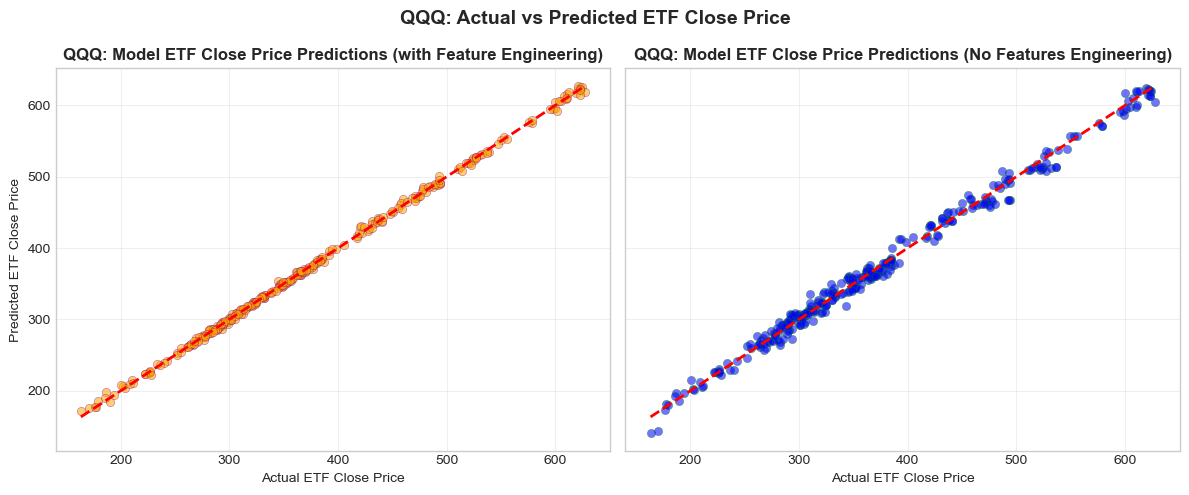

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("{ticker}: Actual vs Predicted ETF Close Price".format(ticker=Ticker), fontsize=14, fontweight="bold")

# Left subplot: With Feature Engineering
ax1.scatter(
    y_test_feat,
    y_pred_feat,
    alpha=0.55,
    color="orange",
    edgecolors="purple",
    linewidths=0.4,
    marker="o"
)
ax1.plot(
    [y_test_feat.min(), y_test_feat.max()],
    [y_test_feat.min(), y_test_feat.max()],
    linestyle="--",
    linewidth=2,
    color="red"
)

ax1.set_xlabel("Actual ETF Close Price")
ax1.set_ylabel("Predicted ETF Close Price")
ax1.set_title("{ticker}: Model ETF Close Price Predictions (with Feature Engineering)".format(ticker=Ticker), fontweight="bold")
ax1.grid(True, alpha=0.3)

# Right subplot: Without Feature Engineering
ax2.scatter(
    y_test_no_feat,
    y_pred_no_feat,
    alpha=0.55,
    color="blue",
    edgecolors="green",
    linewidths=0.4,
    marker="o"
)
ax2.plot(
    [y_test_no_feat.min(), y_test_no_feat.max()],
    [y_test_no_feat.min(), y_test_no_feat.max()],
    linestyle="--",
    linewidth=2,
    color="red"
)

ax2.set_xlabel("Actual ETF Close Price")
ax2.set_title("{ticker}: Model ETF Close Price Predictions (No Features Engineering)".format(ticker=Ticker), fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

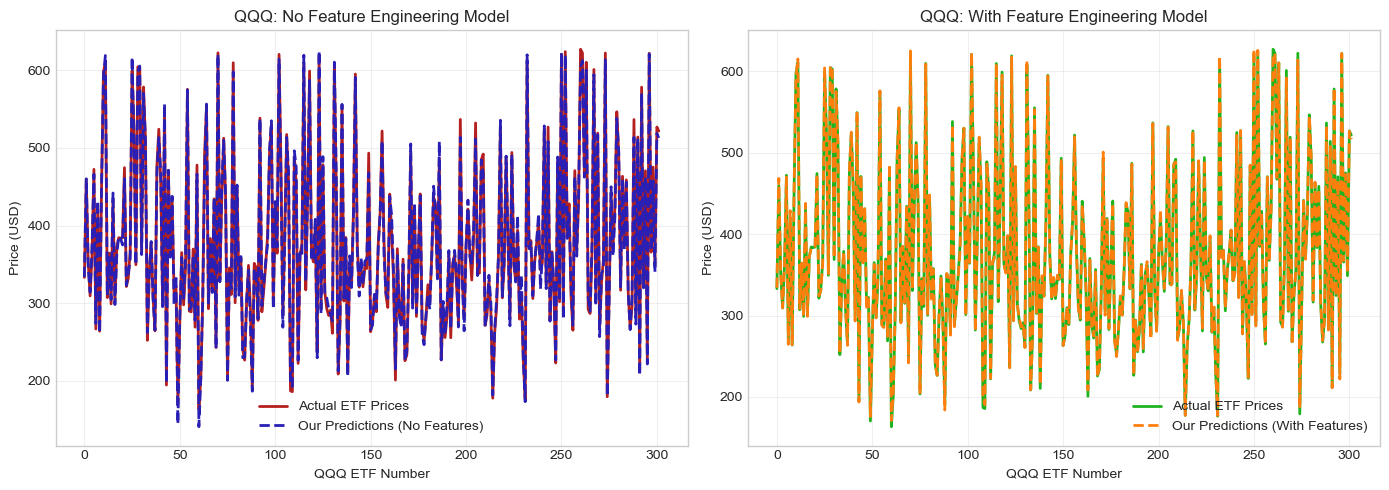

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Common x-axis
x_axis = range(len(y_test_no_feat))

# Left: No Feature Engineering
ax1.plot(x_axis, y_test_no_feat.values, 
         color="#b41f1f", linestyle='-', linewidth=2, 
         label='Actual ETF Prices', 
         )
ax1.plot(x_axis, y_pred_no_feat, 
         color="#291fb4", linestyle='--', linewidth=2,
         label='Our Predictions (No Features)', 
         )
ax1.set_xlabel('{ticker} ETF Number'.format(ticker=Ticker))
ax1.set_ylabel('Price (USD)')
ax1.set_title('{ticker}: No Feature Engineering Model'.format(ticker=Ticker))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: With Feature Engineering
ax2.plot(x_axis, y_test_feat.values,
         color="#1fb41f", linestyle='-', linewidth=2,
         label='Actual ETF Prices')
ax2.plot(x_axis, y_pred_feat,
         color='#ff7f0e', linestyle='--', linewidth=2,
         label='Our Predictions (With Features)')
ax2.set_xlabel('{ticker} ETF Number'.format(ticker=Ticker))
ax2.set_ylabel('Price (USD)')
ax2.set_title('{ticker}: With Feature Engineering Model'.format(ticker=Ticker))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()